## Mueller ellipsometry

The notebook simulates 16 elements of Mueller matrix of Si-binary grating in a wide range of azimuths, which is in the [Publication:](https://www.researchgate.net/profile/Tatiana-Novikova-5/publication/315804617_Comparison_of_spectroscopic_Mueller_polarimetry_standard_scatterometry_and_real_space_imaging_techniques_SEM_and_3D-AFM_for_dimensional_characterization_of_periodic_structures/links/5e2228e192851cafc38c7505/Comparison-of-spectroscopic-Mueller-polarimetry-standard-scatterometry-and-real-space-imaging-techniques-SEM-and-3D-AFM-for-dimensional-characterization-of-periodic-structures.pdf) A. De Martino, M. Foldyna, T. Novikova, D. Cattelan, P. Barritault, C. Licitra, J. Hazart, J.
Foucher, F. Bogeat, Comparison of spectroscopic Mueller polarimetry, standard scatterometry
and real space imaging techniques (SEM and 3D-AFM) for dimensional characterization of
periodic structures. SPIE Proc 6922, 69221P (2008). doi:10.1117/12.772721 



<img src="Images/Si_binary.png" width="400" height="400" align="left" >

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
path_parent=os.path.dirname(os.getcwd())
sys.path.insert(0,path_parent)
from src import Scattering
from src import ReadData 
from src import Computation
from src import Plot
from src import Geo
from matplotlib.offsetbox import AnchoredText

## Optical index

In [2]:
h=4.135667516*1e-15;#[eV s]      
c=299792458         #[m/s]
path_optical_index=path_parent+'/dataNK/'
path_Si=path_optical_index+ 'c-Si_HJY_Modif.txt'
Si_wl, Si_nk=ReadData.read_nk(path_Si)
Si_wl=h*c/Si_wl*10**9      #eV to nm

In [3]:
wavelength_range=np.linspace(450.,825.,50)
e_Si=ReadData.Interpolate_Optical_Index(wavelength_range,Si_wl, Si_nk)
#reflectance and transmission
u_ref=1; u_trn=1;  e_ref=1; e_trn=np.copy(e_Si);  e_air=1

## Input parameters

In [4]:
#Angle
AOI_d = 45
AOI_r=np.radians(AOI_d) 
Azimuth_range_d=[0,15,30,45,60,75,90]
Azimuth_range_r=np.radians(Azimuth_range_d)

#geometry
Lx_cell=1100; Ly_cell=float('inf')  #2D
reso=1
Wx=250 # 2D
Thickness_Sim=[100] # only one layer

# diffraction order in x-y direction
mx=15;my=0    

## Parameters in RCWA

In [5]:
NL=len(Thickness_Sim)
#Geometry
Geo.reso, Geo.Lx_cell, Geo.Ly_cell= reso, Lx_cell, Ly_cell
Geo.mx, Geo.my= mx, my

#Scattering
Scattering.AOI_r =AOI_r

# important
Scattering.Meshgrid()

In [6]:
#layer materials
e_m=[e_Si] # one layer

Geometry=[]
for lth in range(NL):
    layer_lth={}      
    
    layer_lth['Shape']=Geo.Rectangle2D
    layer_lth['e_base']=1
    layer_lth['e_grt']=e_m[lth]
    layer_lth['Critical']=[Wx]
    layer_lth['Center']=[Lx_cell/2]
   
    Geometry.append(layer_lth)  

## Visualization

In [8]:
geo_e=np.array([Plot.Geo_viz(layer_lth) for layer_lth in Geometry])
Plot.Viz_xy(geo_e,pos_layer=[0])

The current version only support x-y view for 3D structures


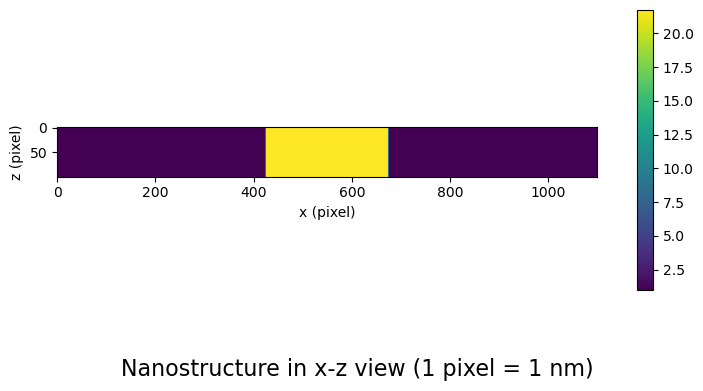

In [8]:
Plot.Viz_z(geo_e,Thickness_Sim)

# Simulation

In [9]:
t0=time.time()
ERC_CONV=[Geo.CONV_layer(wavelength_range,layer_lth) for layer_lth in Geometry]
t_conv=time.time()-t0
print(t_conv)

0.030600309371948242


In [10]:
t0=time.time()

MM=[] # for all azimuth

for Azimuth_r in Azimuth_range_r:
    
    Scattering.Azimuth_r=Azimuth_r
       
    Coeff_XY=[];
    for wth in range(len(wavelength_range)):              
                
        Scattering.KxKy_Component(wavelength_range[wth],e_ref,e_trn[wth])    
        
        # S-layer       
        S_layer=[Scattering.S_Layer(Thickness_Sim[lth],ERC_CONV[lth][wth])  for lth in range(NL)] 
        # Combine for S_global
        S_global=Scattering.S_System(S_layer) 
        
        # compute  R to calculate MM        
        S_global_11=S_global[0];    
        order =Scattering.Nharm//2        
         
        rxS,ryS= Scattering.Optical_Response(S_global_11,'pte') 
        rxP,ryP= Scattering.Optical_Response(S_global_11,'ptm')   
    
        Coeff_XY.append([rxP[order,0],ryP[order,0],rxS[order,0],ryS[order,0]])
    
    Coeff_XY=np.array(Coeff_XY).transpose(1,0) 
    
    rpp,rps,rsp,rss=Scattering.Rotate_SP(Coeff_XY) #rotate AOI, azimuth
    
    # Muller matrix
    m11,m12,m13,m14,m22,m23,m24,m33,m34,m44=Computation.Mueller_m(rpp,rps,rsp,rss)  # 9 mm
    MM_a=np.array([m12/m11,m13/m11,m14/m11,m22/m11,m23/m11,m24/m11,m33/m11,m34/m11,m44/m11])   
    MM_a=Computation.MM9_to_MM16(MM_a)  # thanks to the symmetry of MM, we can calculate 16 mm from 9 mm
    MM_a=MM_a.reshape(4,4,len(wavelength_range)) # 4 x 4 x wl
    
    MM.append(MM_a)
MM=np.array(MM)        

print(time.time() -t0)    

2.5241990089416504


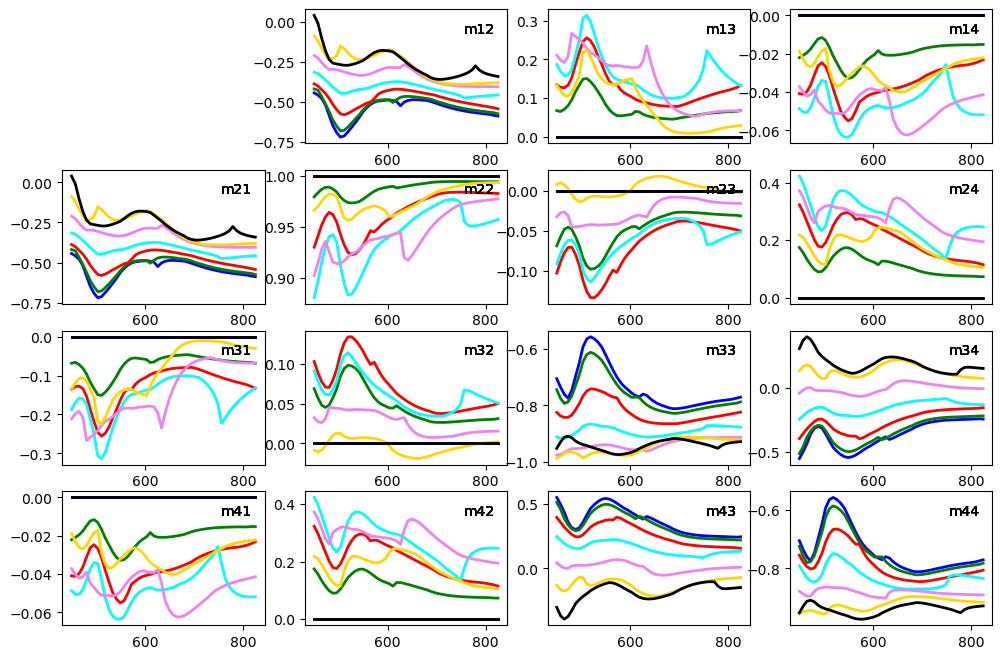

In [11]:
plt.figure(figsize=(12,8))
color=['blue','green','red','cyan','violet','gold','black']

MM=MM.transpose(0,2,1,3)# just a step to convert to row,colum in Mueller matrix correspondent to the author's definition

for i in range(4):
    for j in range(4):
        ax = plt.subplot2grid((4,4), (i,j))
        for idx in range(len(Azimuth_range_d)):               
                            
            ax.plot(wavelength_range,MM[idx][i,j],lw=2,c=color[idx])
            #ax.axis(ymin=-1.1,ymax=1.1)  
            #ax.set_xticks([]);       ax.set_yticks([])
            anchored_text = AnchoredText("m" + str(i+1) +str(j+1), loc=1,frameon=False)           
            ax.add_artist(anchored_text)
            
ax = plt.subplot2grid((4,4), (0,0))
ax.plot(wavelength_range,MM[0][0,0],lw=2,c='white')
ax.axis('off')
anchored_text = AnchoredText("", loc=1,frameon=False)
ax.add_artist(anchored_text)
    
plt.show()